# Neural network for classification of contaminants with MAT

## 1. Formulate/outline the problem: classification

Simple neural network for classification of the contaminants using MAT transcriptomes


In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import wandb
import tensorflow as tf
from tensorflow import keras

2023-08-29 23:03:06.693265: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-29 23:03:06.735418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 23:03:07.429547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
file_name = "gene_counts_NN_training.csv"

In [4]:
data = pd.read_csv(file_name)

## 2. Identify inputs and outputs

In [5]:
data["sample"].value_counts()

sample
R848       5
CRX-527    5
CL-307     5
Pam3       5
LPS        5
PGN        5
IMDM       5
Fla-PA     3
LTA        3
Name: count, dtype: int64

## 3. Prepare data

In [6]:
data_features = data.drop(columns=["sample"])
target = data["sample"]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_features, target, test_size=0.2, random_state=0, shuffle=True, stratify=target
)

In [8]:
y_train.value_counts(), y_test.value_counts()

(sample
 Pam3       4
 R848       4
 IMDM       4
 PGN        4
 LPS        4
 CRX-527    4
 CL-307     4
 Fla-PA     2
 LTA        2
 Name: count, dtype: int64,
 sample
 Pam3       1
 R848       1
 Fla-PA     1
 CRX-527    1
 LPS        1
 LTA        1
 IMDM       1
 PGN        1
 CL-307     1
 Name: count, dtype: int64)

In [9]:
def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.applymap(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


X_train = to_normalize_DESeq2_style(X_train)

X_test = to_normalize_DESeq2_style(X_test)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
encoded_labels = le.transform(y_train)
le_name_mapping = dict(zip(le.classes_, encoded_labels))

In [11]:
le_name_mapping

{'CL-307': 7,
 'CRX-527': 8,
 'Fla-PA': 3,
 'IMDM': 6,
 'LPS': 7,
 'LTA': 4,
 'PGN': 1,
 'Pam3': 3,
 'R848': 4}

In [12]:
from sklearn.feature_selection import chi2, SelectKBest

# Define feature selection
fs = SelectKBest(score_func=chi2, k=500)

# Apply feature selection
X_train = fs.fit_transform(X_train, encoded_labels)

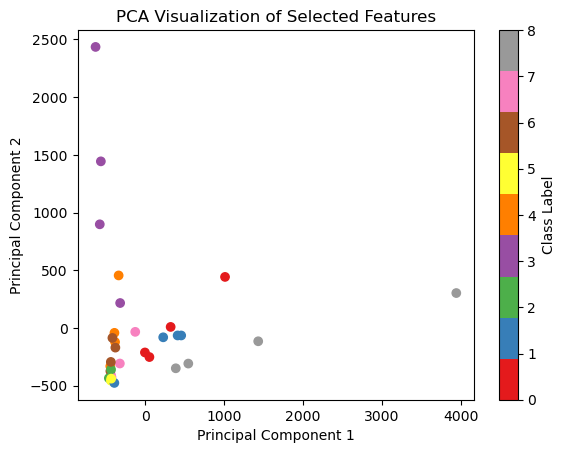

In [13]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)

# Scatter plot
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=encoded_labels, cmap="Set1")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Selected Features")
plt.colorbar(label="Class Label")
plt.show()

In [14]:
# Transform the test feature matrix
X_test = fs.transform(X_test)

In [15]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

## 4. Build an architecture from scratch or choose a pretrained model

In [16]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)

In [17]:
WANDB_NOTEBOOK_NAME = "20230829 NN first sweep"

In [18]:
sweep_config = {
    "method": "bayes",
    "name": "second_sweep",
    "metric": {
        "name": "Validation AUC",
        "goal": "maximize",
    },
    "parameters": {
        "l1": {"values": [32, 56, 84, 128]},
        "l2": {"values": [6, 8, 15, 32]},
        "epochs": {"values": [120, 200, 280]},
        "learning_rate": {"distribution": "uniform", "min": 0.0001, "max": 0.05},
        "batch_size": {
            "values": [
                4,
                6,
                8,
                12,
            ]
        },
        "weights_limit": {"distribution": "uniform", "min": 0.01, "max": 0.08},
        "dropout_rates": {"values": [0.1, 0.2, 0.3, 0.4, 0.5]},
    },
}

In [19]:
sweep_id = wandb.sweep(sweep=sweep_config, project="NN-MATseq")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: vam38hwa
Sweep URL: https://wandb.ai/afanasyeva-team/NN-MATseq/sweeps/vam38hwa


In [20]:
default_config = {
    "l1": 56,
    "l2": 32,
    "dropout_rates": 0.2,
    "batch_size": 15,
    "activation": "relu",
    "weights_limit": 0.01,
    "epochs": 300,
    "learning_rate": 0.001,
    "loss": "categorical_crossentropy",
    "optimizer": "adam",
}

In [ ]:
best_config = {
    "l1": 32,
    "l2": 32,
    "dropout_rates": 0.3,
    "batch_size": 12,
    "activation": "relu",
    "weights_limit": 0.0114,
    "epochs": 280,
    "learning_rate": 0.0156,
    "loss": "categorical_crossentropy",
    "optimizer": "adam",
}

In [21]:
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=0, mode="min", restore_best_weights=True
)

In [22]:
from wandb.keras import WandbCallback


def train():
    with wandb.init(config=default_config) as run:
        dropout_rates = run.config.dropout_rates
        batch_size = run.config.batch_size
        activation = run.config.activation
        weights_limit = run.config.weights_limit
        epochs = run.config.epochs
        learning_rate = run.config.learning_rate
        loss = run.config.loss
        l1 = run.config.l1
        l2 = run.config.l2

        if run.config.optimizer == "adam":
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif run.config.optimizer == "sgd":
            optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
        elif run.config.optimizer == "rmsprop":
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

        inputs = keras.Input(shape=X_train.shape[1])
        x = keras.layers.UnitNormalization()(inputs)

        x = keras.layers.Dense(
            l1,
            activation=activation,
            kernel_regularizer=keras.regularizers.L2(weights_limit),
        )(x)
        x = keras.layers.Dropout(dropout_rates)(x)

        x = keras.layers.Dense(
            l2,
            activation=activation,
            kernel_regularizer=keras.regularizers.L2(weights_limit),
        )(x)
        x = keras.layers.Dropout(dropout_rates)(x)

        outputs = keras.layers.Dense(9, activation="softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name="small_NN")

        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[
                "accuracy",
                keras.metrics.AUC(name="auc"),
            ],
        )

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            verbose=False,
        )

        wandb.log({"AUC": history.history["auc"][-1]})
        wandb.log({"Validation AUC": history.history["val_auc"][-1]})
        wandb.log({"Loss": history.history["loss"][-1]})
        wandb.log({"Validation Loss": history.history["val_loss"][-1]})
        wandb.log({"Accuracy": history.history["accuracy"][-1]})
        wandb.log({"Validation Accuracy": history.history["val_accuracy"][-1]})

In [23]:
count = 200
wandb.agent(sweep_id, train, count=count)

wandb: Agent Starting Run: v4ha74fj with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 56
wandb: 	l2: 6
wandb: 	learning_rate: 0.014684795371303565
wandb: 	weights_limit: 0.036530107777272426
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: afanasyeva-tess (afanasyeva-team). Use `wandb login --relogin` to force relogin
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


2023-08-29 23:03:23.058223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-29 23:03:23.058275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: hpc.research.local
2023-08-29 23:03:23.058284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: hpc.research.local
2023-08-29 23:03:23.058482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 495.29.5
2023-08-29 23:03:23.058510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 495.29.5
2023-08-29 23:03:23.058518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 495.29.5


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.90875
Accuracy,0.59375
Loss,1.65622
Validation AUC,0.94213
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s3zay8q8 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 6
wandb: 	learning_rate: 0.03617534304138352
wandb: 	weights_limit: 0.02994546337772202
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.76801
Accuracy,0.25
Loss,2.1054
Validation AUC,0.84645
Validation Accuracy,0.55556


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ew06mjzv with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 128
wandb: 	l2: 15
wandb: 	learning_rate: 0.02719835734617091
wandb: 	weights_limit: 0.03820539781206553
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.97449
Accuracy,0.75
Loss,1.30238
Validation AUC,0.97685
Validation Accuracy,0.77778


wandb: Agent Starting Run: f36309z1 with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 8
wandb: 	learning_rate: 0.019085885982843383
wandb: 	weights_limit: 0.02581222738150975
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.76044
Accuracy,0.28125
Loss,1.98566
Validation AUC,0.85957
Validation Accuracy,0.44444


wandb: Agent Starting Run: szrkt72p with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.5
wandb: 	epochs: 200
wandb: 	l1: 56
wandb: 	l2: 6
wandb: 	learning_rate: 0.016653570526628754
wandb: 	weights_limit: 0.05107219629234161
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.53894
Accuracy,0.125
Loss,2.16927
Validation AUC,0.5
Validation Accuracy,0.11111


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0b8t0m3v with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 280
wandb: 	l1: 56
wandb: 	l2: 8
wandb: 	learning_rate: 0.016569101798771597
wandb: 	weights_limit: 0.02710669250266189
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.51367
Accuracy,0.03125
Loss,2.16908
Validation AUC,0.5
Validation Accuracy,0.11111


wandb: Agent Starting Run: xaoszguc with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 120
wandb: 	l1: 56
wandb: 	l2: 15
wandb: 	learning_rate: 0.006462967393088682
wandb: 	weights_limit: 0.011124869936646244
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.94086
Accuracy,0.65625
Loss,1.51186
Validation AUC,0.92438
Validation Accuracy,0.55556


wandb: Agent Starting Run: c5xwp9tu with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 200
wandb: 	l1: 56
wandb: 	l2: 32
wandb: 	learning_rate: 0.005436080402110116
wandb: 	weights_limit: 0.01474033840531418
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99554
Accuracy,0.9375
Loss,0.78761
Validation AUC,0.97608
Validation Accuracy,0.66667


wandb: Agent Starting Run: n8t3secf with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 8
wandb: 	learning_rate: 0.007526684896253355
wandb: 	weights_limit: 0.02168038136421672
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.90948
Accuracy,0.5
Loss,1.58966
Validation AUC,0.92824
Validation Accuracy,0.55556


wandb: Agent Starting Run: rngvvsyr with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.033217864949164996
wandb: 	weights_limit: 0.014980789640109071
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98077
Accuracy,0.75
Loss,1.12184
Validation AUC,0.94676
Validation Accuracy,0.77778


wandb: Agent Starting Run: d7ahxzhp with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 15
wandb: 	learning_rate: 0.04620040470532877
wandb: 	weights_limit: 0.0706324700527393
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.5
Accuracy,0.03125
Loss,2.16994
Validation AUC,0.5
Validation Accuracy,0.11111


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 93ehekk8 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.5
wandb: 	epochs: 280
wandb: 	l1: 84
wandb: 	l2: 6
wandb: 	learning_rate: 0.03030178321522796
wandb: 	weights_limit: 0.04840095654876801
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.55469
Accuracy,0.125
Loss,2.16743
Validation AUC,0.5
Validation Accuracy,0.11111


wandb: Agent Starting Run: vek0iwx3 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 120
wandb: 	l1: 56
wandb: 	l2: 15
wandb: 	learning_rate: 0.02977836886625744
wandb: 	weights_limit: 0.0606971967688895
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.86194
Accuracy,0.34375
Loss,2.04119
Validation AUC,0.86343
Validation Accuracy,0.44444


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hjoz2bb9 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 8
wandb: 	learning_rate: 0.015555604492678544
wandb: 	weights_limit: 0.0396192593734517
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.79163
Accuracy,0.3125
Loss,2.10189
Validation AUC,0.87963
Validation Accuracy,0.55556


wandb: Agent Starting Run: 6nmueg2d with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.5
wandb: 	epochs: 200
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.02793903241366815
wandb: 	weights_limit: 0.01560949522559184
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.80475
Accuracy,0.28125
Loss,1.9881
Validation AUC,0.88503
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8k59nsmr with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 8
wandb: 	learning_rate: 0.005294410775514462
wandb: 	weights_limit: 0.070569322366778
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.94293
Accuracy,0.59375
Loss,1.60425
Validation AUC,0.91821
Validation Accuracy,0.55556


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0uj5z72t with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 8
wandb: 	learning_rate: 0.04766358694955034
wandb: 	weights_limit: 0.053551692554685275
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.87805
Accuracy,0.46875
Loss,1.76389
Validation AUC,0.77623
Validation Accuracy,0.22222


wandb: Agent Starting Run: xb5nsl4y with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.029786611298917243
wandb: 	weights_limit: 0.04273079993939695
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.83923
Accuracy,0.3125
Loss,1.91289
Validation AUC,0.78472
Validation Accuracy,0.22222


wandb: Agent Starting Run: swenn488 with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 128
wandb: 	l2: 8
wandb: 	learning_rate: 0.010925909323437047
wandb: 	weights_limit: 0.07410848261027216
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.56689
Accuracy,0.125
Loss,2.16733
Validation AUC,0.5
Validation Accuracy,0.11111


wandb: Agent Starting Run: xziq9j9s with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 120
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.026397015212264223
wandb: 	weights_limit: 0.03634758528852622
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.8429
Accuracy,0.34375
Loss,2.35257
Validation AUC,0.86497
Validation Accuracy,0.44444


wandb: Agent Starting Run: dv8lk1yo with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 8
wandb: 	learning_rate: 0.008263502035549944
wandb: 	weights_limit: 0.05674536375897538
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.84241
Accuracy,0.34375
Loss,1.78574
Validation AUC,0.8642
Validation Accuracy,0.55556


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8jhy5xgp with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.5
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.04879863044362516
wandb: 	weights_limit: 0.01292280833813227
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.52051
Accuracy,0.125
Loss,2.16919
Validation AUC,0.5
Validation Accuracy,0.11111


wandb: Agent Starting Run: wowt90yo with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 128
wandb: 	l2: 15
wandb: 	learning_rate: 0.026748758032287996
wandb: 	weights_limit: 0.02715800091743549
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.90063
Accuracy,0.4375
Loss,1.99549
Validation AUC,0.89429
Validation Accuracy,0.55556


wandb: Agent Starting Run: 28w3e5d6 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 200
wandb: 	l1: 56
wandb: 	l2: 15
wandb: 	learning_rate: 0.01262362617706944
wandb: 	weights_limit: 0.0192009799141008
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.94714
Accuracy,0.59375
Loss,1.53787
Validation AUC,0.95988
Validation Accuracy,0.55556


wandb: Agent Starting Run: y12igrn9 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.016136015739538975
wandb: 	weights_limit: 0.024285397996528735
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96808
Accuracy,0.71875
Loss,1.57046
Validation AUC,0.94522
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0obq1hzw with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 128
wandb: 	l2: 15
wandb: 	learning_rate: 0.02023813606139638
wandb: 	weights_limit: 0.01394264798553567
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99591
Accuracy,0.90625
Loss,0.99244
Validation AUC,0.96528
Validation Accuracy,0.77778


wandb: Agent Starting Run: 9r4odvht with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 15
wandb: 	learning_rate: 0.006140646539319616
wandb: 	weights_limit: 0.01431318657012554
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99567
Accuracy,0.90625
Loss,0.82035
Validation AUC,0.9537
Validation Accuracy,0.66667


wandb: Agent Starting Run: lxylq6q8 with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 56
wandb: 	l2: 8
wandb: 	learning_rate: 0.017279567807657485
wandb: 	weights_limit: 0.021043737095996537
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.86951
Accuracy,0.46875
Loss,2.13532
Validation AUC,0.84722
Validation Accuracy,0.22222


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jj1qyp8e with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.021655962633455608
wandb: 	weights_limit: 0.013237374855708023
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98395
Accuracy,0.84375
Loss,1.26537
Validation AUC,0.96296
Validation Accuracy,0.77778


wandb: Agent Starting Run: 1isb7g4d with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.014820834702392734
wandb: 	weights_limit: 0.01987056007107501
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99963
Accuracy,0.96875
Loss,0.72112
Validation AUC,0.97454
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l9t7ayvf with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.006456872718759221
wandb: 	weights_limit: 0.019870285858603665
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.71071
Validation AUC,0.99383
Validation Accuracy,0.88889


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cphadp10 with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 56
wandb: 	l2: 8
wandb: 	learning_rate: 0.012294867093294245
wandb: 	weights_limit: 0.03286072838347726
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96234
Accuracy,0.6875
Loss,1.27734
Validation AUC,0.90586
Validation Accuracy,0.66667


wandb: Agent Starting Run: n61qrkmf with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 15
wandb: 	learning_rate: 0.00921168698378214
wandb: 	weights_limit: 0.019720294812932224
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98987
Accuracy,0.84375
Loss,0.97749
Validation AUC,0.94059
Validation Accuracy,0.66667


wandb: Agent Starting Run: fgestsh1 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.009544686210913082
wandb: 	weights_limit: 0.02141266573617694
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99847
Accuracy,0.90625
Loss,0.82421
Validation AUC,0.98225
Validation Accuracy,0.77778


wandb: Agent Starting Run: idweco8l with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.008675739162426543
wandb: 	weights_limit: 0.02814778599187727
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.9671
Accuracy,0.75
Loss,1.26122
Validation AUC,0.97917
Validation Accuracy,0.66667


wandb: Agent Starting Run: 0l0lp4k7 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.0002675476109095328
wandb: 	weights_limit: 0.014507509064135737
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99658
Accuracy,0.9375
Loss,1.17519
Validation AUC,0.94444
Validation Accuracy,0.77778


wandb: Agent Starting Run: g5wlu8hx with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 128
wandb: 	l2: 15
wandb: 	learning_rate: 0.027695460615262252
wandb: 	weights_limit: 0.025807554099204794
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.88116
Accuracy,0.46875
Loss,1.66408
Validation AUC,0.91358
Validation Accuracy,0.55556


wandb: Agent Starting Run: 7n1634z7 with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 120
wandb: 	l1: 56
wandb: 	l2: 15
wandb: 	learning_rate: 0.0054636416912294756
wandb: 	weights_limit: 0.015448388060189932
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99188
Accuracy,0.8125
Loss,0.94959
Validation AUC,0.97222
Validation Accuracy,0.66667


wandb: Agent Starting Run: 4tvntbf1 with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 6
wandb: 	learning_rate: 0.00793986606501096
wandb: 	weights_limit: 0.0202247538880718
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.93378
Accuracy,0.75
Loss,1.36544
Validation AUC,0.95139
Validation Accuracy,0.66667


wandb: Agent Starting Run: 86jety3n with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 56
wandb: 	l2: 6
wandb: 	learning_rate: 0.009856574432175295
wandb: 	weights_limit: 0.018341904349417775
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.97089
Accuracy,0.71875
Loss,1.15745
Validation AUC,0.90278
Validation Accuracy,0.44444


wandb: Agent Starting Run: or1735fg with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.009668642744336408
wandb: 	weights_limit: 0.013388473246468378
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.46947
Validation AUC,0.97531
Validation Accuracy,0.66667


wandb: Agent Starting Run: n0f1wfxu with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.003230144657631677
wandb: 	weights_limit: 0.03684402178008961
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99268
Accuracy,0.875
Loss,1.21689
Validation AUC,0.95602
Validation Accuracy,0.77778


wandb: Agent Starting Run: byki19h6 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 56
wandb: 	l2: 32
wandb: 	learning_rate: 0.01319464731475948
wandb: 	weights_limit: 0.011063100545529834
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.47628
Validation AUC,0.95293
Validation Accuracy,0.66667


wandb: Agent Starting Run: oe13etcv with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.005193804303657173
wandb: 	weights_limit: 0.011465278691769998
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.56403
Validation AUC,0.96682
Validation Accuracy,0.66667


wandb: Agent Starting Run: pagrpg3t with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.00097870127766403
wandb: 	weights_limit: 0.023184595750047488
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99677
Accuracy,0.875
Loss,1.14159
Validation AUC,0.96142
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d3sxcnqr with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.003846540848691938
wandb: 	weights_limit: 0.01880222901509307
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99652
Accuracy,0.875
Loss,0.93904
Validation AUC,0.95833
Validation Accuracy,0.66667


wandb: Agent Starting Run: ip1z3jkp with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 6
wandb: 	learning_rate: 0.019277854384817997
wandb: 	weights_limit: 0.018848237157551257
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.97815
Accuracy,0.84375
Loss,1.17706
Validation AUC,0.95988
Validation Accuracy,0.66667


wandb: Agent Starting Run: p6x6qsdd with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.022569347732810153
wandb: 	weights_limit: 0.021560278152231008
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99915
Accuracy,0.9375
Loss,0.78424
Validation AUC,0.94444
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s3c4876v with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 8
wandb: 	learning_rate: 0.0001769423265969326
wandb: 	weights_limit: 0.012327291896862424
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.87671
Accuracy,0.59375
Loss,1.94656
Validation AUC,0.77392
Validation Accuracy,0.55556


wandb: Agent Starting Run: a24h6blv with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 120
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.003593067277396394
wandb: 	weights_limit: 0.013115597830917931
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99854
Accuracy,0.9375
Loss,0.87223
Validation AUC,0.97762
Validation Accuracy,0.66667


wandb: Agent Starting Run: z3jgjngr with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 8
wandb: 	learning_rate: 0.01057508561846544
wandb: 	weights_limit: 0.034272622034893695
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.9353
Accuracy,0.65625
Loss,1.4245
Validation AUC,0.92978
Validation Accuracy,0.44444


wandb: Agent Starting Run: 9wlwbxki with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 6
wandb: 	learning_rate: 0.02296617523441232
wandb: 	weights_limit: 0.024062099757804805
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.86597
Accuracy,0.4375
Loss,1.64288
Validation AUC,0.88503
Validation Accuracy,0.44444


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hi78il5k with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 120
wandb: 	l1: 56
wandb: 	l2: 32
wandb: 	learning_rate: 0.011531205414817863
wandb: 	weights_limit: 0.03418453934850237
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.95892
Accuracy,0.6875
Loss,1.37034
Validation AUC,0.97994
Validation Accuracy,0.77778


wandb: Agent Starting Run: n320ro1w with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.001310532501758841
wandb: 	weights_limit: 0.0277036895233971
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98962
Accuracy,0.8125
Loss,1.21425
Validation AUC,0.98457
Validation Accuracy,0.66667


wandb: Agent Starting Run: w9ykz7ir with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.0036087295776297585
wandb: 	weights_limit: 0.04223329425785717
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99725
Accuracy,0.90625
Loss,1.03082
Validation AUC,0.98148
Validation Accuracy,0.77778


wandb: Agent Starting Run: 44hou6mn with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 120
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.0021650610967236658
wandb: 	weights_limit: 0.017403539007105995
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99927
Accuracy,0.96875
Loss,0.92378
Validation AUC,0.96296
Validation Accuracy,0.66667


wandb: Agent Starting Run: pvv2x5j5 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.00299661650069266
wandb: 	weights_limit: 0.014480850368535522
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99493
Accuracy,0.875
Loss,0.87481
Validation AUC,0.94907
Validation Accuracy,0.66667


wandb: Agent Starting Run: nz219v8d with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.0006838822940579841
wandb: 	weights_limit: 0.03297290205124371
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98364
Accuracy,0.84375
Loss,1.47153
Validation AUC,0.93364
Validation Accuracy,0.66667


wandb: Agent Starting Run: 3mrj29ir with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.007578270326641206
wandb: 	weights_limit: 0.041153332966314
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98407
Accuracy,0.78125
Loss,1.13808
Validation AUC,0.97068
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l6bu9zme with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.004096665104985345
wandb: 	weights_limit: 0.017908617556237287
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99591
Accuracy,0.9375
Loss,1.0206
Validation AUC,0.98071
Validation Accuracy,0.66667


wandb: Agent Starting Run: lzmnl6n6 with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 120
wandb: 	l1: 56
wandb: 	l2: 32
wandb: 	learning_rate: 0.0004036886420726615
wandb: 	weights_limit: 0.02631375666274613
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.93646
Accuracy,0.59375
Loss,1.77535
Validation AUC,0.86651
Validation Accuracy,0.55556


wandb: Agent Starting Run: eetipboi with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 120
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.010895374202124594
wandb: 	weights_limit: 0.02727113717764565
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.92889
Accuracy,0.59375
Loss,1.65475
Validation AUC,0.95833
Validation Accuracy,0.66667


wandb: Agent Starting Run: odi7y7yh with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 120
wandb: 	l1: 128
wandb: 	l2: 8
wandb: 	learning_rate: 0.00893507500413684
wandb: 	weights_limit: 0.011474385264110338
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.93646
Accuracy,0.53125
Loss,1.5026
Validation AUC,0.94059
Validation Accuracy,0.66667


wandb: Agent Starting Run: 6dhtsld3 with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.0044422628556949565
wandb: 	weights_limit: 0.015486366730815711
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99933
Accuracy,0.96875
Loss,0.74381
Validation AUC,0.96451
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rs98wz1s with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.0021008762143057583
wandb: 	weights_limit: 0.020759030986405455
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.81855
Validation AUC,0.97454
Validation Accuracy,0.77778


wandb: Agent Starting Run: 0bkm0nh1 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 15
wandb: 	learning_rate: 0.007969011820842016
wandb: 	weights_limit: 0.029166531492405647
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.95862
Accuracy,0.6875
Loss,1.40675
Validation AUC,0.9375
Validation Accuracy,0.77778


wandb: Agent Starting Run: g7syyk7g with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.0006106581009666202
wandb: 	weights_limit: 0.021150261409121664
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99817
Accuracy,0.9375
Loss,1.01669
Validation AUC,0.97068
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2lxrv56w with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.005160870700043562
wandb: 	weights_limit: 0.010822179203975489
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.44661
Validation AUC,0.93827
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jdmemmhp with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.0017646641057686603
wandb: 	weights_limit: 0.02540789503518214
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99908
Accuracy,0.9375
Loss,0.96724
Validation AUC,0.92824
Validation Accuracy,0.77778


wandb: Agent Starting Run: biy33xkk with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.01118744765588177
wandb: 	weights_limit: 0.037233399763650026
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.97852
Accuracy,0.75
Loss,1.29695
Validation AUC,0.96605
Validation Accuracy,0.66667


wandb: Agent Starting Run: 1a6u6ejd with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.011079549532086732
wandb: 	weights_limit: 0.04164662814444949
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.9848
Accuracy,0.78125
Loss,1.10449
Validation AUC,0.97299
Validation Accuracy,0.66667


wandb: Agent Starting Run: 4fhg6ph3 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.015666878443576494
wandb: 	weights_limit: 0.01136837506521808
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99426
Accuracy,0.90625
Loss,0.97217
Validation AUC,0.99846
Validation Accuracy,1.0


wandb: Agent Starting Run: piui64xf with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.004316456056563921
wandb: 	weights_limit: 0.04270231963367912
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99347
Accuracy,0.90625
Loss,1.16448
Validation AUC,0.96836
Validation Accuracy,0.66667


wandb: Agent Starting Run: awu1we5q with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.004252565762039628
wandb: 	weights_limit: 0.036245841661513976
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.97327
Accuracy,0.8125
Loss,1.2826
Validation AUC,0.93364
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zd3m2zw1 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 15
wandb: 	learning_rate: 0.008654483235276835
wandb: 	weights_limit: 0.03569252495256166
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.91388
Accuracy,0.46875
Loss,1.53978
Validation AUC,0.81559
Validation Accuracy,0.22222


wandb: Agent Starting Run: 4wrhpvcy with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.4
wandb: 	epochs: 120
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.005751167250486112
wandb: 	weights_limit: 0.012457812479159624
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99609
Accuracy,0.875
Loss,0.9965
Validation AUC,0.97454
Validation Accuracy,0.77778


wandb: Agent Starting Run: vaifoc7e with config:
wandb: 	batch_size: 6
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.012140756089590707
wandb: 	weights_limit: 0.016491103063841724
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99194
Accuracy,0.875
Loss,0.88355
Validation AUC,0.95062
Validation Accuracy,0.77778


wandb: Agent Starting Run: zwkajm5b with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 120
wandb: 	l1: 128
wandb: 	l2: 32
wandb: 	learning_rate: 0.003745534898324457
wandb: 	weights_limit: 0.016462895963448725
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.83666
Validation AUC,0.97377
Validation Accuracy,0.77778


wandb: Agent Starting Run: 0wii097v with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.01286174832123833
wandb: 	weights_limit: 0.053500947868638446
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98096
Accuracy,0.84375
Loss,1.30581
Validation AUC,0.95988
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 95jefvwv with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.003594683850838623
wandb: 	weights_limit: 0.017170764597647187
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99988
Accuracy,1.0
Loss,0.66325
Validation AUC,0.97685
Validation Accuracy,0.66667


wandb: Agent Starting Run: 2wi5ya93 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 56
wandb: 	l2: 32
wandb: 	learning_rate: 0.005616116174454033
wandb: 	weights_limit: 0.02115235623927421
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99976
Accuracy,0.96875
Loss,0.69177
Validation AUC,0.97145
Validation Accuracy,0.66667


wandb: Agent Starting Run: a24jk1fb with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 6
wandb: 	learning_rate: 0.02762621876431535
wandb: 	weights_limit: 0.02434030644424453
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.95215
Accuracy,0.6875
Loss,1.26023
Validation AUC,0.95833
Validation Accuracy,0.66667


wandb: Agent Starting Run: m35nw02y with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 128
wandb: 	l2: 6
wandb: 	learning_rate: 0.03780387801305105
wandb: 	weights_limit: 0.011383396921549905
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96338
Accuracy,0.84375
Loss,1.01767
Validation AUC,0.90355
Validation Accuracy,0.44444


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ilun2kn9 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 6
wandb: 	learning_rate: 0.006693962990263728
wandb: 	weights_limit: 0.026927120686175768
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.95862
Accuracy,0.78125
Loss,1.34164
Validation AUC,0.94985
Validation Accuracy,0.66667


wandb: Agent Starting Run: wukznbeg with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.010310072008930566
wandb: 	weights_limit: 0.014059652462450308
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.42994
Validation AUC,0.96528
Validation Accuracy,0.77778


wandb: Agent Starting Run: ug4xedom with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.013741997458070329
wandb: 	weights_limit: 0.04893727015241557
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99017
Accuracy,0.78125
Loss,1.16539
Validation AUC,0.96219
Validation Accuracy,0.66667


wandb: Agent Starting Run: wkkv6i7x with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.012158177248575618
wandb: 	weights_limit: 0.011639203188433768
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99518
Accuracy,0.9375
Loss,0.74516
Validation AUC,0.94599
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: npo3fedf with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.010748525222851487
wandb: 	weights_limit: 0.01684873703731232
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98352
Accuracy,0.8125
Loss,1.08516
Validation AUC,0.95525
Validation Accuracy,0.77778


wandb: Agent Starting Run: o5oy65gm with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.0015625477702378948
wandb: 	weights_limit: 0.010277393331172745
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.78715
Validation AUC,0.94907
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tvalv7fs with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 6
wandb: 	learning_rate: 0.0189087314211592
wandb: 	weights_limit: 0.03911803938838295
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.5
Accuracy,0.125
Loss,2.16732
Validation AUC,0.5
Validation Accuracy,0.11111


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8glu12s6 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 56
wandb: 	l2: 15
wandb: 	learning_rate: 0.00046277484974447286
wandb: 	weights_limit: 0.01110800385053305
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96936
Accuracy,0.75
Loss,1.51073
Validation AUC,0.88349
Validation Accuracy,0.55556


wandb: Agent Starting Run: umamtgmu with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 6
wandb: 	learning_rate: 0.0008738356236288855
wandb: 	weights_limit: 0.010610493088982986
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96301
Accuracy,0.75
Loss,1.31855
Validation AUC,0.89429
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9qjwv8n3 with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 120
wandb: 	l1: 56
wandb: 	l2: 32
wandb: 	learning_rate: 0.014074680415085762
wandb: 	weights_limit: 0.016708629980959216
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96118
Accuracy,0.6875
Loss,1.38649
Validation AUC,0.95833
Validation Accuracy,0.55556


wandb: Agent Starting Run: f1d19eu6 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 84
wandb: 	l2: 32
wandb: 	learning_rate: 0.013930435968491065
wandb: 	weights_limit: 0.037113747443594206
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98724
Accuracy,0.78125
Loss,0.98596
Validation AUC,0.96142
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yq1tu8nr with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 56
wandb: 	l2: 6
wandb: 	learning_rate: 0.0004519601461263993
wandb: 	weights_limit: 0.016871950897981096
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.90979
Accuracy,0.5
Loss,1.80803
Validation AUC,0.77778
Validation Accuracy,0.55556


wandb: Agent Starting Run: qu9158m3 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.0007153254951470822
wandb: 	weights_limit: 0.01098102766490688
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99268
Accuracy,0.9375
Loss,1.10681
Validation AUC,0.94213
Validation Accuracy,0.66667


wandb: Agent Starting Run: qyvdyz96 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.010775711797783348
wandb: 	weights_limit: 0.015248601260321968
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99536
Accuracy,0.90625
Loss,0.82629
Validation AUC,0.97068
Validation Accuracy,0.77778


wandb: Agent Starting Run: o9x728g7 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 56
wandb: 	l2: 8
wandb: 	learning_rate: 0.03996819605073498
wandb: 	weights_limit: 0.010391995557275683
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96466
Accuracy,0.65625
Loss,1.17175
Validation AUC,0.94753
Validation Accuracy,0.66667


wandb: Agent Starting Run: 7o9d4b91 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 6
wandb: 	learning_rate: 0.026171867489019004
wandb: 	weights_limit: 0.019039936001856456
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98737
Accuracy,0.84375
Loss,0.98892
Validation AUC,0.93364
Validation Accuracy,0.77778


wandb: Agent Starting Run: w0ymszgc with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.02020396195648131
wandb: 	weights_limit: 0.016047938064348035
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.96252
Accuracy,0.71875
Loss,1.75481
Validation AUC,0.90818
Validation Accuracy,0.77778


wandb: Agent Starting Run: 13ysonpa with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 6
wandb: 	learning_rate: 0.018748337324664164
wandb: 	weights_limit: 0.01268096490617735
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98181
Accuracy,0.71875
Loss,0.9272
Validation AUC,0.85494
Validation Accuracy,0.44444


wandb: Agent Starting Run: nvxmzmt1 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 56
wandb: 	l2: 32
wandb: 	learning_rate: 0.00533594742825679
wandb: 	weights_limit: 0.011278256936810551
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.54618
Validation AUC,0.94444
Validation Accuracy,0.77778


wandb: Agent Starting Run: 3i13tkgr with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 200
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.00469816790902164
wandb: 	weights_limit: 0.02437378651492569
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.74408
Validation AUC,0.96759
Validation Accuracy,0.66667


wandb: Agent Starting Run: g076bhor with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 6
wandb: 	learning_rate: 0.0023573280820698675
wandb: 	weights_limit: 0.014912716258874857
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.9436
Accuracy,0.65625
Loss,1.43238
Validation AUC,0.89043
Validation Accuracy,0.55556


wandb: Agent Starting Run: 8mbufov0 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.011293151625972272
wandb: 	weights_limit: 0.01720364661038604
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99066
Accuracy,0.84375
Loss,0.84279
Validation AUC,0.96605
Validation Accuracy,0.66667


wandb: Agent Starting Run: 0rijezoc with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.005642730621473635
wandb: 	weights_limit: 0.04742783554713459
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98993
Accuracy,0.84375
Loss,1.07948
Validation AUC,0.98457
Validation Accuracy,0.77778


wandb: Agent Starting Run: 9cz3fc2s with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 8
wandb: 	learning_rate: 0.021577123659135677
wandb: 	weights_limit: 0.0323537766091026
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.97357
Accuracy,0.71875
Loss,1.32074
Validation AUC,0.97917
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 25od26nw with config:
wandb: 	batch_size: 4
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 120
wandb: 	l1: 84
wandb: 	l2: 15
wandb: 	learning_rate: 0.00562203416440661
wandb: 	weights_limit: 0.02149064811977431
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.93103
Accuracy,0.625
Loss,1.56156
Validation AUC,0.94985
Validation Accuracy,0.66667


wandb: Agent Starting Run: 67fr2mwp with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 15
wandb: 	learning_rate: 0.00505855028877111
wandb: 	weights_limit: 0.03892853227312236
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.96665
Validation AUC,0.97377
Validation Accuracy,0.77778


wandb: Agent Starting Run: 2rcbk04d with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 8
wandb: 	learning_rate: 0.006743264429124204
wandb: 	weights_limit: 0.03331496468649725
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.97046
Accuracy,0.71875
Loss,1.20478
Validation AUC,0.95062
Validation Accuracy,0.66667


wandb: Agent Starting Run: h5zjvn9y with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 56
wandb: 	l2: 32
wandb: 	learning_rate: 0.0013676011718965384
wandb: 	weights_limit: 0.017045461702521476
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.60106
Validation AUC,0.96451
Validation Accuracy,0.66667


wandb: Agent Starting Run: ijvpamvm with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.3
wandb: 	epochs: 280
wandb: 	l1: 56
wandb: 	l2: 32
wandb: 	learning_rate: 0.003802082148353948
wandb: 	weights_limit: 0.04321475676784144
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99121
Accuracy,0.90625
Loss,1.03128
Validation AUC,0.93827
Validation Accuracy,0.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5epaqzkm with config:
wandb: 	batch_size: 8
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 56
wandb: 	l2: 32
wandb: 	learning_rate: 0.005433838386233988
wandb: 	weights_limit: 0.025569911965115225
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.6665
Validation AUC,0.96836
Validation Accuracy,0.66667


wandb: Agent Starting Run: v1j7yf21 with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 120
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.0010378379150822131
wandb: 	weights_limit: 0.07832504042345736
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.85083
Accuracy,0.375
Loss,1.97489
Validation AUC,0.82716
Validation Accuracy,0.33333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 88y95hjl with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.011977856405087726
wandb: 	weights_limit: 0.03000268333257636
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.99939
Accuracy,0.9375
Loss,0.69997
Validation AUC,0.98765
Validation Accuracy,0.88889


wandb: Agent Starting Run: tjeuni3l with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.2
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.006075215012673037
wandb: 	weights_limit: 0.04145510161844614
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,0.98206
Accuracy,0.8125
Loss,1.15229
Validation AUC,0.98688
Validation Accuracy,0.77778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5s5sa93y with config:
wandb: 	batch_size: 12
wandb: 	dropout_rates: 0.1
wandb: 	epochs: 280
wandb: 	l1: 32
wandb: 	l2: 32
wandb: 	learning_rate: 0.003774280022489475
wandb: 	weights_limit: 0.02413232341379645
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb: Ctrl + C detected. Stopping sweep.


AUC,▁
Accuracy,▁
Loss,▁
Validation AUC,▁
Validation Accuracy,▁
Validation Loss,▁
AUC,1.0
Accuracy,1.0
Loss,0.62434
Validation AUC,0.98765
Validation Accuracy,0.88889
